In [2]:
##Imports
%matplotlib inline
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
from headers import get_headers
## This is to get the connection to the nba endpoints correctly (hot fix to work until they push changes)
headers = get_headers()

In [3]:
## Build the team name to team_id map
from nba_api.stats.static import teams
nba_teams = teams.get_teams()
list_teams = ['ATL', 'BOS', 'CLE', 'NOP', 'CHI', 'DAL', 'DEN', 'GSW', 'HOU', 'LAC', 'LAL'
        , 'MIA', 'MIL', 'MIN', 'BKN', 'NYK', 'ORL', 'IND', 'PHI', 'PHX', 'POR', 'SAC'
        , 'SAS', 'OKC', 'TOR', 'UTA', 'MEM', 'WAS', 'DET', 'CHA']
i = 0
team_to_id = {}
for t in list_teams:
    team_to_id.update({t: nba_teams[i]['id']})
    i += 1

In [4]:
from nba_api.stats.endpoints import teamgamelog
from nba_api.stats.endpoints import winprobabilitypbp

In [50]:
def plot_game_win_probability(win_probability, title):
    home_pct = win_probability['HOME_PCT'].values
    visit_pct = win_probability['VISITOR_PCT'].values
    
    home_pts = win_probability['HOME_PTS'].values
    visit_pts = win_probability['VISITOR_PTS'].values
    
    ind = range(len(home_pct))
    plt.plot(ind, home_pts, 'g.')
    plt.plot(ind, visit_pts, 'r^')
    plt.title(title)
    if '@' in title:
        home_team = title[-3:]
        away_team = title[:3]
    else:
        home_team = title[:3]
        away_team = title[-3:]
    plt.legend((home_team, away_team))
    teams = {'home': home_team, 'visit': away_team}
    
    ## Annotate the graph with the important points and print out all the plays:
    game_pct = np.abs(home_pct - visit_pct)
    game_inflection = get_inflection_point_occurences(game_pct, 2)

    plt.plot(game_inflection[0:10], 10*[0], 'bX', markersize=20)

    print("Game important plays: ")
    get_influential_plays(win_probability, game_inflection, teams)     
    plt.show()

In [55]:
def generate_win_probability_team(team, NUMBER_GAMES):
    gpbp = teamgamelog.TeamGameLog(team_id=team_to_id[team], headers=headers)
    tgl = gpbp.get_data_frames()[0]
    games = tgl['Game_ID'].values
    matchups = tgl['MATCHUP'].values
    results = tgl['WL'].values
    i = 0
    selected_games = games[0:NUMBER_GAMES]
    for game in selected_games:
        wpp = winprobabilitypbp.WinProbabilityPBP(game_id=game, headers=headers)
        wp = wpp.get_data_frames()[0]
        plot_game_win_probability(wp, matchups[i])
        print("This game resulted with %s getting the %s" % (team, results[i]))
        print("====================================================================")
        i += 1

In [56]:
def get_inflection_point_occurences(team_data, derivative_type):
    second_deriv = np.diff(team_data, n=derivative_type).tolist()
    second_deriv_sorted = sorted(second_deriv, reverse=True)
    inflection_occurences = []
    for i in second_deriv_sorted:
        inflection_occurences.append(second_deriv.index(i) + 2)
    return inflection_occurences    

def get_influential_plays(wp, inflection_occurences, teams):
    events = wp['EVENT_NUM'].values
    descriptions = wp['DESCRIPTION'].values
    quarter = wp['PERIOD'].values
    time_in_quarter = wp['SECONDS_REMAINING'].values
    home_possession = wp['HOME_POSS_IND'].values
    
    event_inflect = events[inflection_occurences]
    di = descriptions[inflection_occurences]
    qi = quarter[inflection_occurences]
    ti = time_in_quarter[inflection_occurences]
    hpi = home_possession[inflection_occurences]
    
    put_the_output(di, ti, qi, hpi, teams)
    
def put_the_output(desc_inflect, tiq_inflect, quarter_inflect, home_posessions, teams):
    number = 10
    home_plays = 0
    visit_plays = 0
    print("Top turning point descriptions: ")
    print("========================================================")
    for i in range(len(desc_inflect)):
        d = desc_inflect[i]
        if d is not None:
            number = number - 1
            if home_posessions[i] == 1:
                home_plays += 1
            else:
                visit_plays += 1
            print('Q%s: %s left %s' % (quarter_inflect[i], convert_secs_into_gametime(tiq_inflect[i]), d))
        if number <= 0:
            break
    print("========================================================")
    print("Important plays: \n%s:%d\n%s:%d" % (teams['home'], home_plays, teams['visit'], visit_plays))
    
def convert_secs_into_gametime(time_left_quarters):
    seconds = time_left_quarters % 60
    minutes = (time_left_quarters - seconds) / 60
    return '%d:%d' % (minutes, seconds)

Game important plays: 
Top turning point descriptions: 
Q3: 6:16 left Gobert 1' Tip Layup Shot (12 PTS)
Q4: 4:55 left Dragic Free Throw 2 of 2 (11 PTS)
Q3: 3:1 left Clarkson 24' 3PT Jump Shot (14 PTS) (Bogdanovic 4 AST)
Q4: 8:48 left Clarkson 25' 3PT Jump Shot (18 PTS)
Q3: 8:48 left Nunn 26' 3PT Jump Shot (9 PTS) (Adebayo 5 AST)
Q4: 10:33 left Niang 24' 3PT Step Back Jump Shot (7 PTS) (Clarkson 3 AST)
Q2: 1:35 left Robinson 25' 3PT Step Back Jump Shot (12 PTS) (Adebayo 4 AST)
Q4: 10:59 left Bradley REBOUND (Off:2 Def:4)
Q4: 2:56 left Bogdanovic 26' 3PT Jump Shot (19 PTS) (Ingles 8 AST)
Q3: 3:57 left Mitchell 9' Driving Floating Jump Shot (18 PTS)
Important plays: 
UTA:4
MIA:6


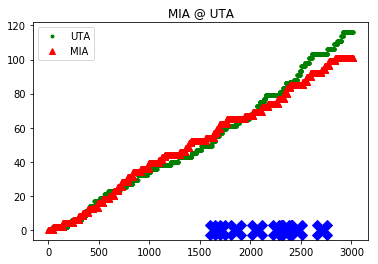

This game resulted with MIA getting the L


In [58]:
generate_win_probability_team('MIA', 1)

Game important plays: 
Top turning point descriptions: 
Q4: 4:40 left Murray 24' 3PT Step Back Jump Shot (28 PTS)
Q4: 0:23 left Lakers Timeout: Regular (Reg.7 Short 0)
Q4: 3:45 left Jokic Lost Ball Turnover (P2.T10)#@#Davis STEAL (2 STL)
Q5: 2:41 left Davis 25' 3PT Jump Shot (32 PTS) (James 14 AST)
Q4: 1:36 left SUB: Craig FOR Morris
Q4: 3:22 left Jokic P.FOUL (P5.PN) (R.Acosta)
Q4: 1:43 left Caruso 2' Cutting Finger Roll Layup Shot (10 PTS) (James 12 AST)
Q4: 2:24 left Davis 1' Tip Layup Shot (26 PTS)
Q3: 11:24 left Green  3PT Jump Shot (3 PTS) (James 7 AST)
Q4: 3:43 left Jokic REBOUND (Off:1 Def:7)
Important plays: 
DEN:6
LAL:4


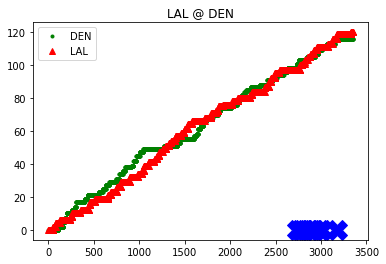

This game resulted with LAL getting the W


In [59]:
generate_win_probability_team('LAL', 1)

Game important plays: 
Top turning point descriptions: 
Q4: 2:28 left Tatum 26' 3PT Jump Shot (27 PTS) (Smart 3 AST)
Q4: 1:30 left Tatum 12' Fadeaway Jumper (29 PTS)
Q4: 3:38 left Theis Free Throw 1 of 2 (11 PTS)
Q4: 2:41 left Hayward REBOUND (Off:2 Def:6)
Q4: 1:7 left Out-of-Bounds
Q4: 3:4 left Out-of-Bounds
Q4: 4:15 left Theis 1' Tip Layup Shot (10 PTS)
Q4: 0:0 left CELTICS Rebound
Q4: 2:11 left Harrell Traveling Turnover (P2.T11)
Q4: 4:16 left Theis REBOUND (Off:3 Def:2)
Important plays: 
BOS:5
LAC:5


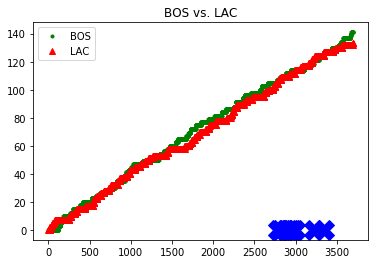

This game resulted with BOS getting the W


In [60]:
generate_win_probability_team('BOS', 1)

Game important plays: 
Top turning point descriptions: 
Q4: 2:28 left Tatum 26' 3PT Jump Shot (27 PTS) (Smart 3 AST)
Q4: 1:30 left Tatum 12' Fadeaway Jumper (29 PTS)
Q4: 3:38 left Theis Free Throw 1 of 2 (11 PTS)
Q4: 2:41 left Hayward REBOUND (Off:2 Def:6)
Q4: 1:7 left Out-of-Bounds
Q4: 3:4 left Out-of-Bounds
Q4: 4:15 left Theis 1' Tip Layup Shot (10 PTS)
Q4: 0:0 left CELTICS Rebound
Q4: 2:11 left Harrell Traveling Turnover (P2.T11)
Q4: 4:16 left Theis REBOUND (Off:3 Def:2)
Important plays: 
BOS:5
LAC:5


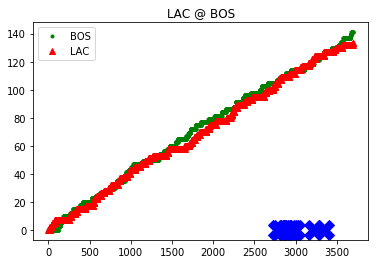

This game resulted with LAC getting the L


In [61]:
generate_win_probability_team('LAC', 1)